In [335]:
import pandas as pd
import os
import math
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Preparación de Datos

In [336]:
GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")
data_card_5_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_5_df.csv"), sep=";", encoding="latin1")


In [337]:
# data_card_5_df.set_index('Provincia', inplace=True)
df = data_card_5_df.drop(columns=['Potencia MWh'])


In [338]:
# Renombrar columnas para que coincidan con el formato esperado
df.columns = ['Provincia'] + [f'Consumo {año}' for año in range(2014, 2024)]

    # Preparar los datos para el modelo
    # Vamos a crear un DataFrame largo con todas las observaciones
datos_modelo = []

# Columnas de consumo (excluyendo 'Provincia')
columnas_consumo = [col for col in df.columns if col.startswith('Consumo')]

for provincia in df['Provincia']:
    # Obtener los consumos de cada provincia
    consumos = df[df['Provincia'] == provincia][columnas_consumo].values[0]
    
    # Crear características: provincia, año y consumo
    for i in range(len(consumos) - 1):
        fila = {
            'Provincia': provincia,
            'Año': 2014 + i,
            'Consumo': consumos[i]
        }
        datos_modelo.append(fila)

# Convertir a DataFrame
df_modelo = pd.DataFrame(datos_modelo)

# Codificar la provincia (one-hot encoding)
df_modelo_encoded = pd.get_dummies(df_modelo, columns=['Provincia'])

# Preparar características y objetivo
X = df_modelo_encoded.drop('Consumo', axis=1)
y = df_modelo_encoded['Consumo']

# Escalar características numéricas
scaler = StandardScaler()

# Identificar columnas numéricas para escalar
columnas_numericas = ['Año']
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Función para evaluar los diferentes modelos probados

In [339]:
def evaluar_modelo(modelo):
    modelo.fit(X_train, y_train)

    # Evaluar modelo
    predicciones_test = modelo.predict(X_test)
    mse_scores = -cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')

    # Preparar predicciones para 2028
    predicciones_2028 = pd.Series(index=df['Provincia'])

    for provincia in df['Provincia']:
        # Crear punto de predicción para 2028
        punto_2028 = X.iloc[-1:].copy()  # Usar la última fila como base
        
        # Actualizar año y consumo actual
        punto_2028['Año'] = 2028
        
        # Restablecer columnas de provincia
        for col in [c for c in X.columns if c.startswith('Provincia_')]:
            punto_2028[col] = 0
        punto_2028[f'Provincia_{provincia}'] = 1
        
        # Escalar características numéricas
        punto_2028[columnas_numericas] = scaler.transform(punto_2028[columnas_numericas])
        
        # Predecir
        prediccion_2028 = modelo.predict(punto_2028)[0]
        predicciones_2028[provincia] = prediccion_2028

    # Predecir consumo para 2028
    resultados = {
            'predicciones_2028': predicciones_2028,
            'MSE_Mean': mse_scores.mean(),
            'R2_Mean': r2_scores.mean(),
        }

    print("Predicciones de consumo para 2028:")
    for provincia, consumo in resultados['predicciones_2028'].items():
        print(f"{provincia}: {consumo:.2f} MWh")

    print("\nError Cuadrático Medio:", resultados['MSE_Mean'])
    print("R-squared Score:", resultados['R2_Mean'])
    
    return resultados


## 1. Predicción con Random Forest

### Descripción del Modelo
Random Forest es un algoritmo de ensamblaje que construye múltiples árboles de decisión y combina sus predicciones. Sus principales ventajas son:
- Robustez contra el overfitting
- Manejo de relaciones no lineales
- Capacidad de capturar interacciones complejas entre características

In [340]:
modelo = RandomForestRegressor(random_state=7)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_rf = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 479049.31 MWh
Ciudad Real: 713928.53 MWh
Cuenca: 207573.80 MWh
Guadalajara: 357382.67 MWh
Toledo: 1062359.55 MWh

Error Cuadrático Medio: 1051402814.2165474
R-squared Score: 0.9839933458632499


## 2. Predicción con Gradient Boosting

### Descripción del Modelo
Gradient Boosting construye un modelo predictivo de forma secuencial, donde cada nuevo modelo corrige los errores del modelo anterior:
- Muy preciso en múltiples tipos de datos
- Maneja bien relaciones no lineales
- Menor riesgo de overfitting comparado con modelos individuales


In [341]:
modelo = GradientBoostingRegressor(random_state=7)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_gb = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 465759.49 MWh
Ciudad Real: 693232.85 MWh
Cuenca: 202460.33 MWh
Guadalajara: 347022.17 MWh
Toledo: 1021568.77 MWh

Error Cuadrático Medio: 1608833780.589548
R-squared Score: 0.9687053277710544


## 3. Predicción con Regresión Polinómica

### Descripción del Modelo
La Regresión Polinómica permite capturar relaciones no lineales mediante transformación de características:
- Útil cuando la relación entre variables no es lineal
- Grados polinómicos diferentes capturan distintos tipos de no linealidad
- Riesgo de overfitting con grados muy altos


In [342]:
modelo = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())
])
param_grid = {
    'poly__degree': [2, 3, 4]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_rp = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 256095.83 MWh
Ciudad Real: 538642.89 MWh
Cuenca: 19812.93 MWh
Guadalajara: 176032.91 MWh
Toledo: 922772.55 MWh

Error Cuadrático Medio: 1773496461.071376
R-squared Score: 0.9644938376598523


## 4. Predicción con Árbol de Decisión

### Descripción del Modelo
Los Árboles de Decisión dividen recursivamente los datos basándose en criterios de división:
- Muy interpretables
- Capturan relaciones no lineales
- Tienden a sobreajustarse si no se controla la profundidad


In [343]:
modelo = DecisionTreeRegressor()
param_grid = {
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_dt = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 465755.76 MWh
Ciudad Real: 693235.16 MWh
Cuenca: 202449.61 MWh
Guadalajara: 347015.29 MWh
Toledo: 1021579.81 MWh

Error Cuadrático Medio: 1608929194.5600688
R-squared Score: 0.9687015295680442


## Elección del mejor modelo para nuestra hipótesis

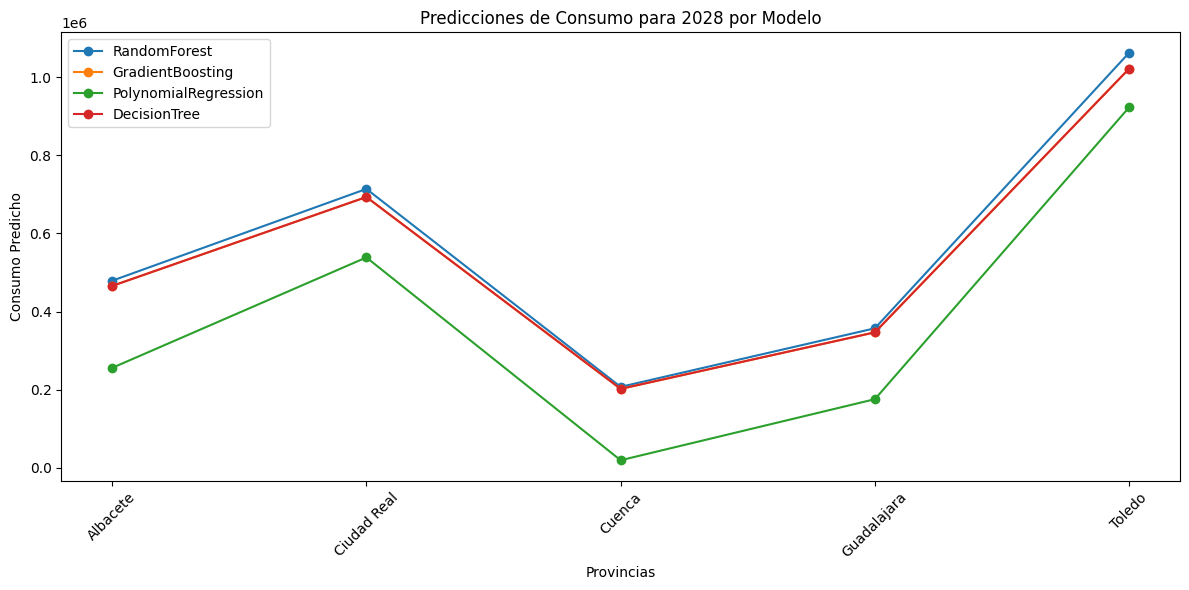

In [344]:
predicciones_2028 = {}
predicciones_2028['RandomForest'] = resultados_rf['predicciones_2028']
predicciones_2028['GradientBoosting'] = resultados_gb['predicciones_2028']
predicciones_2028['PolynomialRegression'] = resultados_rp['predicciones_2028']
predicciones_2028['DecisionTree'] = resultados_dt['predicciones_2028']

# Gráfico de predicciones para 2028
plt.figure(figsize=(12, 6))
for nombre, predicciones in predicciones_2028.items():
    plt.plot(predicciones.index, predicciones.values, label=nombre, marker='o')

plt.title('Predicciones de Consumo para 2028 por Modelo')
plt.xlabel('Provincias')
plt.ylabel('Consumo Predicho')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que la regresión polinómica es la que más difiere y eso va de la mano con el peor valor de R2. Luego tenemos muy similares los otros modelos pero hay uno que sobresale a los demás, el RandomForest tiene el menor cuadrado de las medias de los errores y el coeficiente de determinación R2 más cercano a 1.

## Predicción del consumo en el año 2028

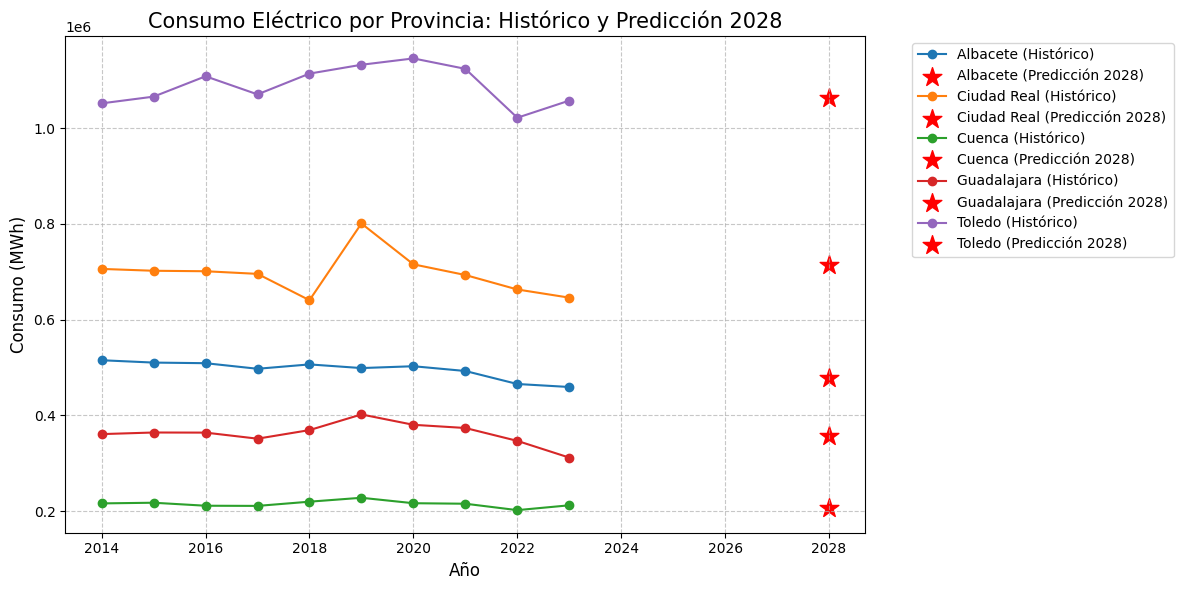

In [345]:
datos = df
predicciones_2028 = resultados_rf['predicciones_2028']
plt.figure(figsize=(12, 6))

# Columnas de consumo
columnas_consumo = [col for col in datos.columns if col.startswith('Consumo')]

# Configurar estilo
plt.style.use('default')

# Graficar series históricas y predicciones
for provincia in datos['Provincia']:
    # Datos históricos
    consumos_historicos = datos[datos['Provincia'] == provincia][columnas_consumo].values[0]
    años_historicos = list(range(2014, 2024))
    
    # Graficar línea histórica
    plt.plot(años_historicos, consumos_historicos, marker='o', label=f'{provincia} (Histórico)')
    
    # Añadir punto de predicción para 2028
    plt.scatter(2028, predicciones_2028[provincia], marker='*', 
                color='red', s=200, 
                label=f'{provincia} (Predicción 2028)')

plt.title('Consumo Eléctrico por Provincia: Histórico y Predicción 2028', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [346]:
potencia_placas = data_card_5_df['Potencia MWh']
potencia_placas.index = data_card_5_df['Provincia']

prediccion_placas = (predicciones_2028 / potencia_placas) / 0.2

print("Tomando como datos placas de 1m^2 y teniendo en cuenta que suelen tener un rendimiento del 20%")
print("Predicciones de placas para 2028:")
for provincia, placas in prediccion_placas.items():
    print(f"{provincia}: {math.ceil(placas)} placas")
    
print("Total de placas necesarias en 2028 en Castilla La Mancha:", math.ceil(sum(prediccion_placas)))
    

Tomando como datos placas de 1m^2 y teniendo en cuenta que suelen tener un rendimiento del 20%
Predicciones de placas para 2028:
Albacete: 1461990 placas
Ciudad Real: 2197770 placas
Cuenca: 645424 placas
Guadalajara: 1147349 placas
Toledo: 3263921 placas
Total de placas necesarias en 2028 en Castilla La Mancha: 8716453
